## Lectures
 - [Value functions approximation - RL by David Silver](https://www.youtube.com/watch?v=UoPei5o4fps&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=6)
    - Differentiable function approximators
    - Incremental methods
    - Batch methods (DQN)

### Reading:
 - [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/pdf/1312.5602.pdf)
 - [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
  - Preprocessing.
  - Deep Q-learning.
  - Hyperparameters

### Coding
This week we will apply Deep Q-Networks (DQN) to Pong.

### Explore the environment:
- https://gym.openai.com/envs/Pong-v0/

### install env: 
 - pip install atari-py

In [1]:
import gym
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize
import random 
import torch
import os
import time
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
class Preprocessor():
    def __init__(self, game, h, w, device, n_frame=4):
        self.game = game
        self.h, self.w = h, w
        self.set_box(game)
        self.n_frame = n_frame
        self.history = []
        self.device = device
        self.delta_value = 256
    def set_box(self, game):
        if self.game == 'pong':
            self.box = [35, 193, 0, self.w]
        
    def phi(self, rbg, to_tensor=True):
        stack = None
        frame = self.rgb2gray(rbg)
        self.history.append(frame)
        if len(self.history) == self.n_frame:
            stack = np.stack(self.history)
            if to_tensor:
                stack = self.to_tensor([stack])
        self.history = self.history[-(self.n_frame-1):]
        return stack
    
    def to_tensor(self, frames):
        frame = torch.from_numpy(np.stack(frames)).float().to(self.device)
        return frame
    
    def rgb2gray(self, rgb):
        rgb = rgb[self.box[0]:self.box[1], self.box[2]: self.box[3]]
        rgb = np.array(Image.fromarray(rgb).resize((84,84)))
        gray = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
        gray = gray / self.delta_value
        return gray

In [4]:
preprocessor = Preprocessor('pong', 210, 160, device)

In [5]:
env = gym.make("Pong-v0")
observation = env.reset()

In [6]:
observation.shape

(210, 160, 3)

In [7]:
for action_id, name in enumerate(env.unwrapped.get_action_meanings()):
    print(action_id, name)

0 NOOP
1 FIRE
2 RIGHT
3 LEFT
4 RIGHTFIRE
5 LEFTFIRE


In [8]:
NOOP, RIGHT, LEFT= 0, 2, 3

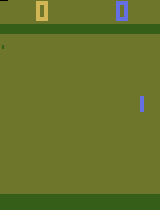

In [9]:
Image.fromarray(observation)

In [10]:
ob = env.reset()

(0.0, False, {'ale.lives': 0}, (84, 84))

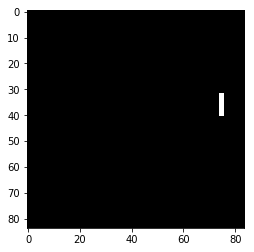

In [11]:
observation, reward, done, info = env.step(0)
frame = preprocessor.rgb2gray(observation)
plt.imshow(frame, cmap = "gray")
reward, done, info, frame.shape

In [12]:
frame.max()

0.5748781249999999

In [13]:
ob = env.reset()

In [14]:
# i = 92
# t = D.D_win[i][0][0][0].cpu().numpy()
# plt.imshow(t, cmap = "gray")
# time.sleep(0.2)

In [15]:
# frame.shape

(0.0, False, {'ale.lives': 0}, (84, 84), torch.Size([1, 4, 84, 84]))

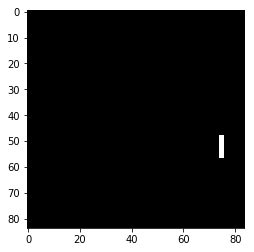

In [16]:
for i in range(4):
    observation, reward, done, info = env.step(3)
    frame = preprocessor.rgb2gray(observation)
    frames = preprocessor.phi(observation)
frames = preprocessor.phi(observation)
plt.imshow(frame, cmap = "gray")
reward, done, info, frame.shape, frames.shape

In [17]:
# Test preprocess:

In [18]:
def plot_images(images,):
    assert len(images) == 4
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
def show_image_from_frames(frames):
    images = np.array(frames.cpu())[0]
    plot_images(images)

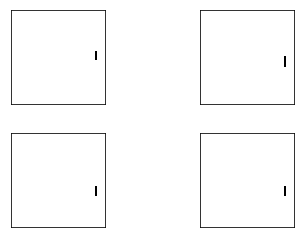

In [19]:
show_image_from_frames(frames)

### Build model:

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,8,stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(), 
            nn.Linear(512, n_actions))
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [21]:
# Test model:

In [22]:
def run_optimizer(Q_net, frames, lr=0.1, n_iter=1, is_train = [True, False, False], MSE=nn.MSELoss()):
    optimizer = torch.optim.RMSprop(Q_net.parameters(), lr=lr)
    for i in range(n_iter):
        loss = None
        y_hat = Q_net(frames)
        print(f"y_hat {y_hat}.")
        idx = torch.LongTensor([[0]]).to(device)
        y_0 = torch.gather(y_hat, 1, idx)
        print(f"y_0 {y_0}.")
        idx = torch.LongTensor([[1]]).to(device)
        y_1 = torch.gather(y_hat, 1, idx)
        print(f"y_1 {y_1}")
        idx = torch.LongTensor([[2]]).to(device)
        y_2 = torch.gather(y_hat, 1, idx)
        print(f"y_2 {y_2}")
        optimizer.zero_grad()
        
        if is_train[0]:
            y =  torch.from_numpy(np.array([-1])).float().to(device)
            loss1 = MSE(y_0, y).to(device)
            if loss:
                loss += loss1
            else:
                loss = loss1
        
        if is_train[1]:
            y =  torch.from_numpy(np.array([1])).float().to(device)
            loss2 = MSE(y_1, y).to(device)
            if loss:
                loss += loss2
            else:
                loss = loss2
                
        if is_train[2]:
            y =  torch.from_numpy(np.array([1])).float().to(device)
            loss3 = MSE(y_2, y).to(device)
            if loss:
                loss += loss3
            else:
                loss = loss3
                
        loss.backward()
        optimizer.step()
        
        print(f"new y_hat {Q_net(frames)}")

In [23]:
Q_net = DQN([4], 3).to(device)
run_optimizer(Q_net, frames, lr=1, n_iter=2, is_train=[True, True, True])

y_hat tensor([[ 0.1216,  0.0957, -0.0241]], device='cuda:0', grad_fn=<AddmmBackward>).
y_0 tensor([[0.1216]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[0.0957]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[-0.0241]], device='cuda:0', grad_fn=<GatherBackward>)
new y_hat tensor([[-96953960.,  96988952.,  96947872.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
y_hat tensor([[-96953960.,  96988952.,  96947872.]], device='cuda:0',
       grad_fn=<AddmmBackward>).
y_0 tensor([[-96953960.]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[96988952.]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[96947872.]], device='cuda:0', grad_fn=<GatherBackward>)
new y_hat tensor([[ 12239248., -12242504., -12243192.]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [24]:
Q_net = DQN([4], 3).to(device)
run_optimizer(Q_net, frames, lr=0.01, n_iter=2, is_train=[True, True, True])

y_hat tensor([[ 0.0031, -0.0331,  0.0368]], device='cuda:0', grad_fn=<AddmmBackward>).
y_0 tensor([[0.0031]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[-0.0331]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[0.0368]], device='cuda:0', grad_fn=<GatherBackward>)
new y_hat tensor([[-499.1908,  497.9409,  498.9920]], device='cuda:0',
       grad_fn=<AddmmBackward>)
y_hat tensor([[-499.1908,  497.9409,  498.9920]], device='cuda:0',
       grad_fn=<AddmmBackward>).
y_0 tensor([[-499.1908]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[497.9409]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[498.9920]], device='cuda:0', grad_fn=<GatherBackward>)
new y_hat tensor([[ 118.9477, -116.9591, -122.7569]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [25]:
Q_net = DQN([4], 3).to(device)
run_optimizer(Q_net, frames, lr=0.0001, n_iter=2, is_train=[True, True, True])

y_hat tensor([[-0.0186,  0.0989, -0.0904]], device='cuda:0', grad_fn=<AddmmBackward>).
y_0 tensor([[-0.0186]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[0.0989]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[-0.0904]], device='cuda:0', grad_fn=<GatherBackward>)
new y_hat tensor([[-1.1356,  1.0272,  1.2238]], device='cuda:0', grad_fn=<AddmmBackward>)
y_hat tensor([[-1.1356,  1.0272,  1.2238]], device='cuda:0', grad_fn=<AddmmBackward>).
y_0 tensor([[-1.1356]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[1.0272]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[1.2238]], device='cuda:0', grad_fn=<GatherBackward>)
new y_hat tensor([[-0.6805,  0.9789,  0.4365]], device='cuda:0', grad_fn=<AddmmBackward>)


In [26]:
Q_net = DQN([4], 3).to(device)
run_optimizer(Q_net, frames, lr=0.00003, n_iter=4, is_train=[True, True, True])

y_hat tensor([[ 0.1456, -0.1430, -0.0242]], device='cuda:0', grad_fn=<AddmmBackward>).
y_0 tensor([[0.1456]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[-0.1430]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[-0.0242]], device='cuda:0', grad_fn=<GatherBackward>)
new y_hat tensor([[-0.3034,  0.1838,  0.2527]], device='cuda:0', grad_fn=<AddmmBackward>)
y_hat tensor([[-0.3034,  0.1838,  0.2527]], device='cuda:0', grad_fn=<AddmmBackward>).
y_0 tensor([[-0.3034]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[0.1838]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[0.2527]], device='cuda:0', grad_fn=<GatherBackward>)
new y_hat tensor([[-0.4747,  0.3839,  0.4468]], device='cuda:0', grad_fn=<AddmmBackward>)
y_hat tensor([[-0.4747,  0.3839,  0.4468]], device='cuda:0', grad_fn=<AddmmBackward>).
y_0 tensor([[-0.4747]], device='cuda:0', grad_fn=<GatherBackward>).
y_1 tensor([[0.3839]], device='cuda:0', grad_fn=<GatherBackward>)
y_2 tensor([[0.4468]], d

In [27]:
# good learning rate is about 0.00003

### Data loader:

In [28]:
# This DataLoader will save data and generate data for training model.

class DataLoader():
    def __init__(self, batch_size, win_buffer_start_size=1000, loss_buffer_start_size=3001, buffer_capacity=40000):
        self.batch_size = batch_size
        self.D_win = []
        self.D_lose = []
        self.buffer_capacity = buffer_capacity
        self.loss_buffer_start_size = loss_buffer_start_size
        self.win_buffer_start_size = win_buffer_start_size 
        
    def reset(self):
        self.D_win = []
        self.D_lose = []
        
    def add_samples(self, game, win):
        if win:
            for step in game:
                self.D_win.append(step)
            if len(self.D_win) > self.buffer_capacity:
                self.D_win = self.D_win[-(self.buffer_capacity - 5000):]
        else:
            for step in game:
                self.D_lose.append(step)
            if len(self.D_lose) > self.buffer_capacity:
                self.D_lose = self.D_lose[-(self.buffer_capacity - 5000):]
            
    def get_sample(self):
        batch = None
        is_mixed = True
        if len(self.D_win) > self.win_buffer_start_size:
            batch_win = random.sample(self.D_win, self.batch_size // 2)
            batch_lose = random.sample(self.D_lose, self.batch_size // 2)
            batch = batch_win + batch_lose
        elif len(self.D_lose) > self.loss_buffer_start_size:
            is_mixed = False
            batch = random.sample(self.D_lose, self.batch_size)
        return batch, is_mixed
    
    def __len__(self):
        return len(self.D_win), len(self.D_lose)
    
    def get_item(self, idx, is_win=False):
        if is_win:
            D = self.D_win
        else:
            D = self.D_lose
        if idx < 0 or idx > len(D) - 1:
            return None
        return D[idx]

In [29]:
2 * 0.99 ** 50

1.2100121342750727

### Algorithm 1: deep Q-learning with experience replay.

In [110]:
class Policy():
    def __init__(self, Q, n_action, device, win_gamma=1, loss_gamma=1, epsilon=1, alpha=0.8, learning_rate=0.00003):
        self.win_gamma = win_gamma
        self.loss_gamma = loss_gamma
        self.episode = 1
        self.alpha = alpha
        self.epsilon = epsilon
        self.EPS_DECAY_RATE = 0.989
        self.n_action = n_action
        self.learning_rate = learning_rate
        self.action_mapper = [NOOP, RIGHT, LEFT]
        self.final_exploration = 0.05
        self.device = device
        # Step 1: Initilize Q(State, Action)
        self.net = Q.to(device)
        self.loss_fn = nn.MSELoss(reduction='sum')
        self.model_path = './models/DQN/checkpoint.pth.tar'
        self.load_model()
        self.min_loss = 1
        self.max_iter = 5
    def update_epsilon(self,):
        self.epsilon *= self.EPS_DECAY_RATE
    
    def update_min_loss(self,):
        self.min_loss *= self.EPS_DECAY_RATE
        
    def save_model(self,):
        torch.save({'state_dict': self.net.state_dict()}, self.model_path)
        
    def load_model(self,):
        if os.path.isfile(self.model_path):
            checkpoint = torch.load(self.model_path)
            self.net.load_state_dict(checkpoint['state_dict'])
        self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=self.learning_rate)
        
    def to_tensor(self, frames):
        frame = torch.from_numpy(np.stack(frames)).float().to(self.device)
        return frame
    
    def update_state_dict(self, Q):
        self.net.load_state_dict(Q.net.state_dict())
        
    def get_y_hat(self, batch):
        batch_state = [sample[0] for sample in batch]
        y_Q = self.net(torch.cat(batch_state))

        batch_a = [[sample[1]] for sample in batch]
        idx = torch.LongTensor(batch_a).to(device)
        y_Q = torch.gather(y_Q, 1, idx)
        return y_Q
    
    def update_Q(self, y, batch, verbose=False):
        keep_running = True
        count = 0
        while keep_running:
            self.optimizer.zero_grad()
            y_hat = self.get_y_hat(batch)
            loss = self.loss_fn(y_hat, y)
            if verbose:
                print(loss)
            loss.backward()
            self.optimizer.step()
            count += 1
            keep_running = (loss.item() > max(0.3, self.min_loss)) & (count < self.max_iter)
            
    def get_target(self, batch, is_mixed=False, verbose=False):
        r_t = torch.from_numpy(np.array([sample[2] for sample in batch])).float().to(self.device)
        if verbose:
            print('r_t', r_t)
        s_t_plus_1 = [sample[3] for sample in batch]
        
        q_t_plus_1 = self.net(torch.cat(s_t_plus_1))
        if verbose:
            print('q_t_plus_1 for all action: ', q_t_plus_1)
        q_t_plus_1 = q_t_plus_1.max(dim=1)[0]
        if verbose:
            print('q_t_plus_1', q_t_plus_1)
        if is_mixed:
            q_t_plus_1[0:len(q_t_plus_1)//2] = q_t_plus_1[0:len(q_t_plus_1)//2] * self.win_gamma
            q_t_plus_1[len(q_t_plus_1)//2:] = q_t_plus_1[len(q_t_plus_1)//2:] * self.loss_gamma
        else:
            q_t_plus_1 = q_t_plus_1 * self.loss_gamma
        if verbose:
            print('q_t_plus_1 with gamma', q_t_plus_1)
        idx = (r_t != -1) & (r_t != 1)
        q_t_plus_1 = torch.clamp(q_t_plus_1, min=-0.95, max=0.95)
        r_t[idx] += q_t_plus_1[idx]
        # do net train target value
        r_t = r_t.view(-1,1).detach()
        # to ensure value in taget in range [-1,1]
        return r_t
    
    def get_next_action(self, state, is_e_greedy=False):
        if is_e_greedy and np.random.random() < max(self.epsilon, self.final_exploration):
            next_action = np.random.randint(self.n_action)
            return next_action, self.action_mapper[next_action]
        
        output = self.net(state)
        _, next_action = torch.max(output, dim=1)
        next_action = next_action.item()
        return next_action, self.action_mapper[next_action]
    

In [31]:
0.989 ** 200

0.10946072477880486

In [32]:
preprocessor = Preprocessor('pong', 210, 160, device)
D = DataLoader(32)

In [33]:
epsilon=1
Q = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
# Q_hat = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
# Q_hat.update_state_dict(Q)

In [100]:
def play(env, Q, preprocessor, is_e_greedy=False, render=False):
    Q.net.train(False)
    game = []
    for i in range(5):
        observation, reward, done, info = env.step(0)
        phi_t = preprocessor.phi(observation)
    for t in range(10000):
        if render:
            time.sleep(0.1)
            env.render()
            time.sleep(0.1)
        index_a_t, a_t = Q.get_next_action(phi_t, is_e_greedy=is_e_greedy)
        x_t_plus_1, r_t, done, info = env.step(a_t)
        phi_t_plus_1 = preprocessor.phi(x_t_plus_1)
        
        game.append((phi_t, index_a_t, r_t, phi_t_plus_1))
        
        if (r_t == -1) or (r_t == 1) or done:
            return game, env, r_t == 1, done
        # repair for next step
        phi_t = phi_t_plus_1
    Q.net.train(True)

In [35]:
# let play
# expected behavior: the bar will move randomly because the Q net is created randomly.
env.reset()
game, env, win, done = play(env, Q, preprocessor, is_e_greedy=False, render=True)

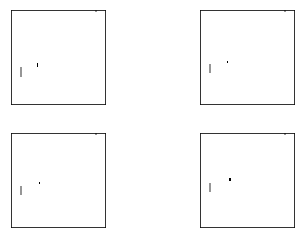

In [36]:
show_image_from_frames(game[46][0])

In [37]:
Q.net(game[50][0])

tensor([[ 0.0593, -0.1079,  0.0416]], device='cuda:0', grad_fn=<AddmmBackward>)

In [38]:
from collections import Counter
print(len(game))
actions = Counter([t[1]for t in game])
# expected uniform distribution on actions because we use randome action in play.
actions

81


Counter({0: 37, 1: 29, 2: 15})

In [39]:
# let play the second round:
game, env, win, done = play(env, Q, preprocessor, is_e_greedy=False, render=True)

In [40]:
print(len(game))
actions = Counter([t[1]for t in game])
# expected uniform distribution on actions because we use randome action in play.
actions

40


Counter({1: 18, 2: 8, 0: 14})

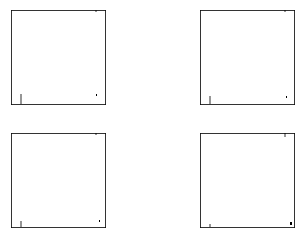

In [41]:
show_image_from_frames(game[38][0])

In [42]:
# let play the third round:
game, env, win, done = play(env, Q, preprocessor, is_e_greedy=False, render=False)

In [43]:
win, done

(False, False)

In [44]:
print(len(game))
actions = Counter([t[1]for t in game])
# expected uniform distribution on actions because we use randome action in play.
actions

40


Counter({1: 17, 2: 16, 0: 7})

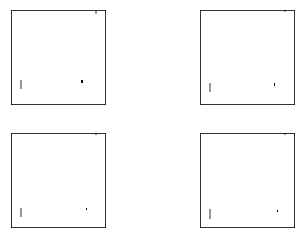

In [45]:
show_image_from_frames(game[30][0])

In [46]:
# run and generate sample:
def generate_game(n_game, D, Q, preprocessor, env, is_e_greedy=True, verbose=True, is_update_epsilon=False):
    for _ in range(n_game):
        done = False
        env.reset()
        n_win, n_loss = 0, 0
        while done == False:
            game, env, win, done = play(env, Q, preprocessor, is_e_greedy=is_e_greedy)
            if win:
                n_win+=1
            else:
                n_loss+=1
            if win and verbose:
                print("Yes! We have one game win.")

            if (done or win) & is_update_epsilon:
                Q.update_epsilon()

            D.add_samples(game, win)
        if (n_win > 0):
            print(f"Win {n_win} - {n_loss} Loss ")

In [47]:
env.reset()
generate_game(1, D, Q, preprocessor, env, is_e_greedy=True, verbose=True)

In [48]:
generate_game(30, D, Q, preprocessor, env, True, verbose=False)

Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 2 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 


In [49]:
len(D.D_win)

1062

In [50]:
MAX_N_GAMES = 1
n_iteration = 3

In [53]:
Q_net = DQN([4], 3).to(device)
optimizer = torch.optim.RMSprop(Q_net.parameters(), lr=0.00003)
MSE = nn.MSELoss(reduction='sum')

In [54]:
batch, is_mixed = D.get_sample()
np.array([sample[2] for sample in batch]).reshape(4, 8)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [55]:
def test_gradient_batch(batch, MSE, optimizer, n=4):
    batch_state = [sample[0] for sample in batch]
    batch_state = torch.cat(batch_state)
    y = torch.from_numpy(np.array([sample[2] for sample in batch])).float().to(device).view(-1, 1)
    print(y.view(-1, 8))
    for i in range(n):
        y_Q = Q_net(batch_state)
        batch_a = [[sample[1]] for sample in batch]
        idx = torch.LongTensor(batch_a).to(device)
        y_Q = torch.gather(y_Q, 1, idx)
        print(y_Q.view(-1, 8))
        loss = MSE(y_Q, y)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_Q = Q_net(batch_state)
        y_Q = torch.gather(y_Q, 1, idx)
    print(y_Q.view(-1, 8))

In [56]:
test_gradient_batch(batch, MSE, optimizer, n=6)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], device='cuda:0')
tensor([[-0.0720,  0.1031,  0.0685, -0.0389,  0.0808, -0.0054, -0.1607, -0.0227],
        [-0.0557, -0.0109,  0.0473,  0.1372, -0.1473, -0.0161, -0.0605, -0.0143],
        [-0.0322,  0.0214,  0.0276,  0.1022, -0.0185,  0.0533, -0.0304,  0.0408],
        [ 0.0132, -0.0756,  0.1195,  0.0008, -0.0009, -0.0309, -0.0365,  0.0341]],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor(1.1101, device='cuda:0', grad_fn=<MseLossBackward>)
tensor([[ 0.0739, -0.6511, -0.3978, -0.0436, -0.7182,  0.0430,  0.1324, -0.2517],
        [ 0.2236, -0.0159, -0.1377, -0.6162,  0.2810,  0.0916,  0.0735, -0.0327],
        [ 0.0509, -0.0308, -0.0455, -0.3640, -0.2061, -0.4521,  0.0261, -0.2046],
        [-0.2492, -0.0550, -0.7259, -0.0733, -0.1372,  0.1897,  0.4313, -0.1077]],
       device='cu

In [57]:
batch_state = [sample[0] for sample in batch[0:2]]
batch_state = torch.cat(batch_state)
Q_net(batch_state)

tensor([[ 0.0014,  0.0237, -0.0429],
        [ 0.0121,  0.0321, -0.0013]], device='cuda:0', grad_fn=<AddmmBackward>)

In [58]:
batch_state = [sample[0] for sample in batch[0:4]]
batch_state = torch.cat(batch_state)
Q_net(batch_state)

tensor([[-0.0094,  0.0179, -0.0462],
        [-0.0079,  0.0123,  0.0200],
        [-0.1172, -0.0071,  0.0041],
        [ 0.0998,  0.0497,  0.0264]], device='cuda:0', grad_fn=<AddmmBackward>)

In [59]:
# Problem: Inconsistent results during test using different batch size.
# https://discuss.pytorch.org/t/solved-inconsistent-results-during-test-using-different-batch-size/2265/7
Q_net.train(False)

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [60]:
batch_state = [sample[0] for sample in batch[0:2]]
batch_state = torch.cat(batch_state)
Q_net(batch_state)

tensor([[ 0.0203,  0.0123, -0.0877],
        [ 0.0201,  0.0124, -0.0882]], device='cuda:0', grad_fn=<AddmmBackward>)

In [61]:
batch_state = [sample[0] for sample in batch[0:4]]
batch_state = torch.cat(batch_state)
Q_net(batch_state)

tensor([[ 0.0203,  0.0123, -0.0877],
        [ 0.0201,  0.0124, -0.0882],
        [ 0.0207,  0.0119, -0.0879],
        [ 0.0204,  0.0122, -0.0883]], device='cuda:0', grad_fn=<AddmmBackward>)

In [62]:
Q_net.train(True)

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [63]:
batch_state = [sample[0] for sample in batch[0:1]]
batch_state = torch.cat(batch_state)
Q_net(batch_state)

tensor([[-0.0242,  0.0177, -0.0190]], device='cuda:0', grad_fn=<AddmmBackward>)

In [64]:
batch_state = [sample[0] for sample in batch[0:2]]
batch_state = torch.cat(batch_state)
Q_net(batch_state)

tensor([[ 0.0014,  0.0237, -0.0429],
        [ 0.0121,  0.0321, -0.0013]], device='cuda:0', grad_fn=<AddmmBackward>)

In [65]:
# Test policy:
epsilon=1
Q = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
optimizer = torch.optim.RMSprop(Q.net.parameters(), lr=0.00003)
MSE = nn.MSELoss(reduction='sum')

In [66]:
def test_Q_gradient_batch(batch, MSE, optimizer, n=4):
    batch_state = [sample[0] for sample in batch]
    batch_state = torch.cat(batch_state)
    y = torch.from_numpy(np.array([sample[2] for sample in batch])).float().to(device).view(-1, 1)
    print(y.view(-1, 8))
    for i in range(n):
        y_Q = Q.net(batch_state)
        batch_a = [[sample[1]] for sample in batch]
        idx = torch.LongTensor(batch_a).to(device)
        y_Q = torch.gather(y_Q, 1, idx)
        print(y_Q.view(-1, 8))
        loss = MSE(y_Q, y)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_Q = Q.net(batch_state)
        y_Q = torch.gather(y_Q, 1, idx)
    print(y_Q.view(-1, 8))

In [67]:
test_Q_gradient_batch(batch, MSE, optimizer, n=4)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], device='cuda:0')
tensor([[ 0.0191, -0.0713, -0.0943, -0.0842,  0.0360,  0.2310, -0.1595, -0.1352],
        [ 0.0217, -0.0563, -0.0078, -0.0798, -0.1396, -0.0139,  0.0446, -0.3363],
        [ 0.0770,  0.0210,  0.0215, -0.0004,  0.0140,  0.0119,  0.0067,  0.0021],
        [-0.0662, -0.0350,  0.0100, -0.0906,  0.0276,  0.0571, -0.0440,  0.0668]],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor(1.3242, device='cuda:0', grad_fn=<MseLossBackward>)
tensor([[ 0.1741,  0.8264,  0.7287, -0.1680,  0.5364, -0.4661,  0.3601,  0.9394],
        [-0.4023,  0.1807, -0.0324,  0.5865,  0.1375,  0.0104, -0.4595,  1.1423],
        [-0.3393, -0.0095, -0.0080, -0.1200, -0.2264, -0.1098,  0.1799, -0.0657],
        [ 0.3802, -0.0274, -0.5195,  0.0108, -0.1818, -0.0300,  0.2466, -0.1604]],
       device='cu

In [68]:
batch_state = [sample[0] for sample in batch]
batch_state = torch.cat(batch_state)
Q.net(batch_state)

tensor([[ 0.0816, -0.0400, -0.0585],
        [-0.0343,  0.0014, -0.2505],
        [ 0.0655, -0.0200, -0.1409],
        [-0.0636, -0.0151, -0.0233],
        [-0.0580, -0.0450, -0.1127],
        [ 0.0690, -0.1088,  0.0017],
        [-0.0319, -0.0160, -0.0928],
        [ 0.0487, -0.0044, -0.2034],
        [-0.0101,  0.0350,  0.0290],
        [ 0.0165, -0.0195, -0.0867],
        [ 0.0483, -0.0359, -0.1145],
        [-0.0672, -0.0040, -0.0375],
        [-0.0382, -0.1638,  0.0187],
        [ 0.1266,  0.0538, -0.0691],
        [-0.0659,  0.0424,  0.0014],
        [ 0.0812, -0.0172,  0.0654],
        [-0.1187, -0.0616,  0.0008],
        [ 0.0418, -0.0875, -0.0561],
        [ 0.0391, -0.0430, -0.1211],
        [ 0.0005,  0.0548,  0.0168],
        [ 0.0401, -0.0828, -0.3504],
        [ 0.1339, -0.1551, -0.0699],
        [ 0.0651, -0.0325, -0.0915],
        [ 0.0801, -0.1221, -0.1572],
        [-0.0789,  0.0051, -0.0269],
        [ 0.0656, -0.1043, -0.0020],
        [ 0.2726, -0.2533,  0.0113],
 

In [69]:
# Test policy function:
epsilon=1
Q = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
optimizer = torch.optim.RMSprop(Q.net.parameters(), lr=0.00003)
MSE = nn.MSELoss(reduction='sum')

In [70]:
Q.min_loss = 1

In [71]:
y = torch.from_numpy(np.array([sample[2] for sample in batch])).float().to(device).view(-1, 1)
print(y.view(-1, 8))

Q.update_Q(y, batch, verbose=True)
    
print(Q.get_y_hat(batch).view(-1, 8))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], device='cuda:0')
tensor(1.1867, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8.5487, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.4312, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.7793, device='cuda:0', grad_fn=<MseLossBackward>)
tensor([[-0.0022, -0.0168, -0.0263, -0.0339,  0.0104, -0.0202, -0.0124, -0.0567],
        [ 0.0401, -0.0200, -0.0096, -0.0026, -0.0066, -0.0278,  0.0081,  0.0041],
        [ 0.0342, -0.0224,  0.0021, -0.0135, -0.2814, -0.0176, -0.0175, -0.0130],
        [-0.0068, -0.0389, -0.0083, -0.0214, -0.0301, -0.0213, -0.0999, -0.0358]],
       device='cuda:0', grad_fn=<ViewBackward>)


In [72]:
Q.net.train(False)

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [73]:
print(Q.get_y_hat(batch[0:1]))

tensor([[-0.0008]], device='cuda:0', grad_fn=<GatherBackward>)


In [74]:
print(Q.get_y_hat(batch[0:2]))

tensor([[-0.0008],
        [-0.0007]], device='cuda:0', grad_fn=<GatherBackward>)


In [75]:
Q.net.train(True)

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [76]:
print(Q.get_y_hat(batch[0:1]))

tensor([[-0.1021]], device='cuda:0', grad_fn=<GatherBackward>)


In [77]:
print(Q.get_y_hat(batch[0:2]))

tensor([[-0.0259],
        [-0.0304]], device='cuda:0', grad_fn=<GatherBackward>)


In [78]:
Q.net(batch[0][0])

tensor([[-0.0862, -0.1021,  0.0036]], device='cuda:0', grad_fn=<AddmmBackward>)

In [79]:
# test on real case:
# Test policy function:
epsilon=1
Q = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
Q_hat = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)

In [80]:
Q_hat.update_state_dict(Q)

In [81]:
y = Q.get_target(batch, is_mixed=is_mixed)
print(y.view(-1, 8))

tensor([[ 0.0074,  0.1195, -0.0486,  0.0025,  0.0565,  0.0503,  0.0558,  0.0411],
        [-0.0303,  0.0290,  0.0559,  0.0349,  0.0328,  0.0607,  0.0286,  0.0412],
        [ 0.1727, -0.0060,  0.0056,  0.1467, -0.9500,  0.0618,  0.0068,  0.0778],
        [ 0.0703,  0.0616,  0.0033,  0.0531,  0.0734,  0.1421,  0.0809,  0.0576]],
       device='cuda:0')


In [82]:
y = Q_hat.get_target(batch, is_mixed=is_mixed)
print(y.view(-1, 8))

tensor([[ 0.0074,  0.1195, -0.0486,  0.0025,  0.0565,  0.0503,  0.0558,  0.0411],
        [-0.0303,  0.0290,  0.0559,  0.0349,  0.0328,  0.0607,  0.0286,  0.0412],
        [ 0.1727, -0.0060,  0.0056,  0.1467, -0.9500,  0.0618,  0.0068,  0.0778],
        [ 0.0703,  0.0616,  0.0033,  0.0531,  0.0734,  0.1421,  0.0809,  0.0576]],
       device='cuda:0')


In [83]:
Q.min_loss = 0.1

In [84]:
Q.max_iter

5

In [85]:
Q.update_Q(y, batch, verbose=True)
    
print(Q.get_y_hat(batch).view(-1, 8))

tensor(1.5458, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.6665, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.7362, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5512, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5625, device='cuda:0', grad_fn=<MseLossBackward>)
tensor([[-0.0005,  0.1009, -0.0498, -0.1386,  0.0319, -0.1417,  0.0360,  0.0333],
        [-0.2061,  0.0067,  0.0690,  0.0159, -0.1185,  0.0783, -0.1370,  0.0264],
        [ 0.0090, -0.0061,  0.0127,  0.0120, -0.4373,  0.0805, -0.0067,  0.0854],
        [ 0.0663, -0.0550, -0.2034,  0.0606, -0.0536,  0.1214,  0.1101,  0.0725]],
       device='cuda:0', grad_fn=<ViewBackward>)


In [86]:
MAX_N_GAMES = 1
n_iteration = 1
def train_model(n_iteration, verbose=True):
    for i in range(n_iteration):
        if verbose:
            print(i)
        batch, is_mixed = D.get_sample()
        rewards = [t[2] for t in batch]
        if verbose:
            print(np.array(rewards).reshape(4,8), is_mixed)
        y = Q_hat.get_target(batch, is_mixed=is_mixed).detach()
        if verbose:
            print(y.view(4,8))
        old_y = Q.get_y_hat(batch)
        if verbose:
            print(old_y.view(4,8))
        Q.update_Q(y, batch, verbose)
        new_y = Q.get_y_hat(batch)
        if verbose:
            print(new_y.view(4,8))

In [87]:
Q.max_iter = 4

In [88]:
Q.min_loss = 0.1

In [89]:
train_model(1, verbose=True)

0
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]] True
tensor([[ 0.0165,  0.0141,  0.1223,  0.0340,  0.0078,  0.0432, -0.0014,  0.0141],
        [ 0.9500,  0.1047,  0.0335, -0.0104, -0.0546, -0.0117,  0.0117,  0.0191],
        [ 0.0254,  0.1386,  0.0619,  0.0143,  0.2000,  0.0937,  0.0309,  0.0577],
        [ 0.0843,  0.0747,  0.0938,  0.0463, -0.9500,  0.0887,  0.1153,  0.0701]],
       device='cuda:0')
tensor([[-0.0758, -0.0074, -0.0049, -0.0122,  0.0387,  0.0133,  0.0323, -0.2301],
        [ 0.0279,  0.0072, -0.3359, -0.0533, -0.0028, -0.3018,  0.1840, -0.0007],
        [-0.0404, -0.0380, -0.0237, -0.0570,  0.0305, -0.0961, -0.1829, -0.2810],
        [-0.1721, -0.0180,  0.0097, -0.1717, -0.3964,  0.0032,  0.1510, -0.0014]],
       device='cuda:0', grad_fn=<ViewBackward>)
tensor(1.9272, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1417, device='cuda:0', grad_fn=<MseLossBackward>)
tens

In [98]:
# train model:
# looking for value of reward 1 and -1:
MAX_N_GAMES = 200
n_iteration = 200
Q.min_loss = 1
Q.max_iter = 4
for episode in range(MAX_N_GAMES):
    if episode % 5 == 0:
        print(episode)
    observation = env.reset()
    
    generate_game(1, D, Q, preprocessor, env, is_e_greedy=True, verbose=False, is_update_epsilon=False)

    train_model(n_iteration, verbose=False)
        
    Q_hat.update_state_dict(Q)
    Q.update_epsilon()
    Q.update_min_loss()
Q.save_model()

0
Win 1 - 21 Loss 
Win 5 - 21 Loss 
Win 2 - 21 Loss 
5
Win 6 - 21 Loss 
Win 2 - 21 Loss 
Win 1 - 21 Loss 
Win 4 - 21 Loss 
Win 1 - 21 Loss 
10
Win 3 - 21 Loss 
Win 3 - 21 Loss 
Win 1 - 21 Loss 
Win 4 - 21 Loss 
15
Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
20
Win 1 - 21 Loss 
Win 3 - 21 Loss 
Win 7 - 21 Loss 
Win 2 - 21 Loss 
Win 2 - 21 Loss 
25
Win 3 - 21 Loss 
Win 2 - 21 Loss 
Win 3 - 21 Loss 
Win 3 - 21 Loss 
30
Win 4 - 21 Loss 
Win 5 - 21 Loss 
Win 1 - 21 Loss 
Win 3 - 21 Loss 
35
Win 1 - 21 Loss 
Win 2 - 21 Loss 
Win 8 - 21 Loss 
Win 3 - 21 Loss 
40
Win 2 - 21 Loss 
Win 3 - 21 Loss 
Win 1 - 21 Loss 
Win 1 - 21 Loss 
45
Win 3 - 21 Loss 
Win 4 - 21 Loss 
Win 1 - 21 Loss 
Win 4 - 21 Loss 
Win 1 - 21 Loss 
50
Win 4 - 21 Loss 
Win 2 - 21 Loss 
Win 2 - 21 Loss 
Win 3 - 21 Loss 
55
Win 6 - 21 Loss 
Win 5 - 21 Loss 
Win 3 - 21 Loss 
Win 1 - 21 Loss 
Win 2 - 21 Loss 
60
Win 3 - 21 Loss 
Win 2 - 21 Loss 
Win 2 - 21 Loss 
Win 3 - 21 Loss 
Win 3 - 21 Loss 
65
Win 5 - 

In [99]:
Q.epsilon, Q.min_loss

(0.03621491574616716, 0.1094607247788048)

In [101]:
_ = env.reset()

In [102]:
_ = play(env, Q, preprocessor, render=True)

In [112]:
epsilon= Q.epsilon
Q = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon, learning_rate=1e-5)
Q_hat = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)

In [113]:
Q_hat.update_state_dict(Q)

In [115]:
# train model:
# looking for value of reward 1 and -1:
MAX_N_GAMES = 20
n_iteration = 200
Q.min_loss = 0.5
Q.max_iter = 4
for episode in range(MAX_N_GAMES):
    if episode % 5 == 0:
        print(episode)
    observation = env.reset()
    
    generate_game(1, D, Q, preprocessor, env, is_e_greedy=True, verbose=False, is_update_epsilon=False)

    train_model(n_iteration, verbose=False)
        
    Q_hat.update_state_dict(Q)
    Q.update_epsilon()
    Q.update_min_loss()
Q.save_model()

0
Win 7 - 21 Loss 
Win 6 - 21 Loss 
Win 2 - 21 Loss 
Win 8 - 21 Loss 
Win 2 - 21 Loss 
5
Win 12 - 21 Loss 
Win 2 - 21 Loss 
Win 7 - 21 Loss 
Win 1 - 21 Loss 
Win 2 - 21 Loss 
10
Win 11 - 21 Loss 
Win 15 - 21 Loss 
Win 4 - 21 Loss 
Win 6 - 21 Loss 
Win 7 - 21 Loss 
15
Win 10 - 21 Loss 
Win 2 - 21 Loss 
Win 6 - 21 Loss 
Win 3 - 21 Loss 
Win 8 - 21 Loss 


In [116]:
_ = env.reset()

In [117]:
_ = play(env, Q, preprocessor, render=True)